# Algoritmo de búsqueda primero mejor ambicioso

Dentro de los algoritmos de búsqueda heurística, el algoritmo de primero mejor ambicioso es aquel que usa como función de prioridad únicamente a la heurística, sin tomar en cuenta el costo. 

Una <b>heurística</b> es una función sobre los estados que nos da información sobre qué tan cercanos estamos a la meta. Es decir, nos da información externa al problema de búsqueda que podemos aprovechar para obtener una solución óptima. Cabe señalar que la heurística depende del problema que estemos tratando.

Aquí presentamos la aplicación del algoritmo de primero mejor ambicioso al problema del laberinto con tráfico. Para esto definirmeos una heurística adecuada a este problema y veremos cómo afecta el hecho de que el algoritmo sea "ambicioso" al costo de la solución.

### Construcción del problema

El problema será el del laberinto, incluyendo regiones con tráfico pesado (costo 3) y tráfico ligero (costo 2). Construimos un mapa en donde indicamos la cantidad de tráfico, la posición del agente (azul), y la meta (verde).

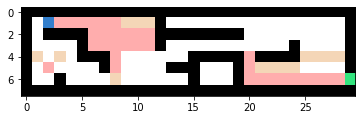

In [1]:
import numpy as np
from maze_simulator import TrafficMaze

mapa = """
##############################
# o------...#                #
# ####------########         #
#    #------#           #    #
#. . ###-      #####-####....#
# -    #-    ###   #-....    #
#  #    .      #   #---------x
##############################
"""

ent = TrafficMaze(mapa)
ent.draw()

## Heurística

Recordemos que la heurístia es una función $h: V \to \mathbb{R}$ que nos da información de la posición del estado del nodo con respecto a la meta. Ya que nuestra problema se busca llegar de un punto A (la posición inicial del agente) a un punto B (la meta), resulta natural utilizar como heurística una distancia. En particular proponemos el uso de la distancia euclideana, definida como:

$$h(n) = \sqrt{(x_n - x_{goal})^2 + (y_n-y_{goal})^2}$$

Donde $(x_n,y_n)$ son las coordenadas de la posición del agente en el estado representado por el nodo $n$ y $(x_{goal}, y_{goal})$ son las coordenadas de la meta.

In [2]:
def h(state, goal):
    """Heurísitca euclideana"""
    x1,y1 = state
    x2,y2 = goal
    #Obtiene distancia euclideana
    dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    
    return dist

## Implementación del algoritmo

El algoritmo de primero mejor ambicioso debe expandir en cada caso el nodo que tiene el valor de la distancia más pequeña. Para esto usamos una pila de prioridad.

### Pila

La pila de prioridad va a tomar como elemento de salida aquel que tenga la prioridad más alta. En general, esta prioridad se toma como el argumento que maximiza una función de prioridad. Sin embargo, como aquí estamos usando una métrica, lo ideal es que está sea lo más pequeña posible (que estemos más cerca de la meta). Por tanto, en lugar de tomar el elemento con el valor más grande, tomaremos el elemento con el valor más pequeño, que equivale a tomar aquel elemento que maximiza el valor negativo de la heurística.

In [3]:
class PriorityQueue(object):
    """Clase de una cola de prioridad en los problemas de búsqueda."""
    def __init__(self,f=lambda x: 1):
        self.queue = []
        self.f = f
  
    def __str__(self):
        return ' '.join([str(q) for q in self.queue])
  
    def isEmpty(self):
        return self.queue == []
  
    def push(self, element):
        """Agrega elementos a la pila"""
        self.queue.append(element)
  
    def pop(self):
        """Saca de la pila el elemento con mayor valor f."""
        #Encuentra el elemento máximo en base al costo
        min_element = np.argmin([element.f for element in self.queue])
        #Guarda el elemento máximo
        item = self.queue[min_element]
        #Borra este elemento de la cola
        del self.queue[min_element]
    
        return item

#### Nodos y expansión

Los nodos guardarán la información necesaria para poder aplicar el algoritmo. El método de expansión será el mismo que hemos utilizado antes. Sin embargo, cabe resaltar la construcción de la función $f$, pues como podemos ver, se toma sólo el valor de la heurística; esto es:

$$f(n) = h(n)$$

In [4]:
class Node(object):
    """Clase para crear nodos con sus atributos."""
    def __init__(self):
        self.state = (0,0)
        self.parent = None 
        self.action = None
        self.cost = 0
        self.f = 0
        
    def __str__(self):
        if self.parent == None:
            return "State: {}".format(self.state)
        else:
            return "State: {}, Action: {}, Parent: {}".format(self.state,self.action,self.parent.state)   
            
def expand(problem, node):
    """Función para expandir los nodos dado el problema"""
    s = node.state 
    for action in problem.actions(s):
        #Aplica la función de resultado
        new_s = problem.result(s, action)
        #Crea el nuevo nodo
        new_node,new_node.state,new_node.parent,new_node.action = Node(),new_s,node,action
        #No agregamos el costo, pero lo consideramos para ver el costo final del camino
        new_node.cost = node.cost + problem.cost(s,action,new_s)
        #Agrega sólo la heurística al nodo
        new_node.f = h(s,new_s)
        
        yield new_node

### Algoritmo de primero mejor ambicioso

El algoritmo de primero mejor ambicioso se basa en el algoritmo de primero mejor, pero en donde la función de prioridad está definida por la heurística. Es por esto que se le llama ambicioso, pues no toma en cuenta el costo y busca llegar a la meta lo más rápido posible sin importar que el costo sea grande. Este algoritmo usa un método de Late-Goal Test para revisar si el nodo es final.

In [5]:
def GreedySearch(problem):
    """Algoritmo de búsqueda ambiciosa."""
    #Almacenamiento de nodos
    nodes = []
    #Nodo inicial
    node = Node()
    node.state = problem.initial
    #Frontera con cola de prioridad
    frontier = PriorityQueue()
    frontier.push(node)
    #Nodos alcanzados
    reached = {problem.initial:node}

    #Mientras la frontera no esté vacía
    while frontier.isEmpty() == False:
        #Pop en frontera
        node = frontier.pop()
        #Guarda el nodo en la lista
        nodes.append(node)
        #Actualiza el estado del problema
        problem.state = node.state

        #Si llega a un estado final se detiene 
        #y regresa el camino de nodos
        if problem.state == problem.goal:
            return nodes

        #Expande el nodo actual
        expantion = expand(problem, node)
        for child in expantion:
            #print(child.f)
            #Guarda estado de los hijos
            state = child.state
            #Guarda los hijos no alcanzados o que tengan menor costo
            if state not in reached.keys() or child.f < reached[state].f:
                reached[state] = child
                frontier.push(child)

    #Si no logra llegar a un nodo final
    #El algoritmo regresa mensaje de error
    return "No se ha logrado llegar a un estado final."

#### Aplicación del algoritmo

Finalmente, podemos aplicar el método al problema del laberingo con los casos de tráfico y ver cómo se desempeña este algoritmo. 

In [6]:
tree = GreedySearch(ent)

El resultado obtenido se muestra a continuación:

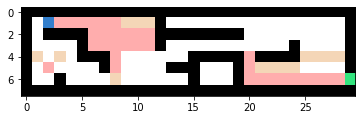

Solución


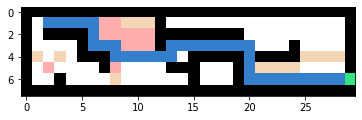

Costo total: 73


In [7]:
def get_path(search_tree, root):
    """Recupera la solución."""
    leaf = search_tree[::-1][0]
    parent = leaf.parent
    path = [leaf, parent]
    while parent.state != root:
        parent = parent.parent
        path.append(parent)
        
    return path[::-1]

ent.draw()
#Visualiza la solución
prev_s = ent.initial
for n in get_path(tree, ent.initial):
    ent.move(prev_s, n.state)
    prev_s = n.state

print('Solución')
ent.draw()
print('Costo total: {}'.format(tree[-1].cost))

Como se puede observar, el camino obtenido parece el más corto en cuestión de distancia, pues hemos buscado encontrar un camino que sea minimice una distancia euclideana. Sin embargo, el costo del camino no es el más bajo esperado, pues de hecho el agente pasa por varias secciones que contienen tráfico alto.